# MLOps

In this notebook we will see examples of the problems that can arise when putting ML models in productions.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

We will use the Ames housing dataset, which we have previously looked at in regards to regression, as example.

In [4]:
ames = pd.read_csv("AmesHousing.csv")

For simplicity, we will only use the following variables: 

- `Lot Area` (the size of the lot in square feet)
- `Overall Cond` (rating of the overall condition of the house)
- `Year Built` (Original construction year)
- `Gr Liv Area` (Above grade (ground) living area in square feet)
- `TotRms AbvGrd`(Total rooms above grade, excluding bathrooms)
- `Mo Sold` (Month Sold)
- `Yr Sold` (Year Sold)
- `Bldg Type` (type of house)
- `Neighborhood` (locations of the house within Ames city)
- `SalePrice` (the price the house was sold at)

In [5]:
ames = ames[["Lot Area", "Overall Cond", "Year Built", "Gr Liv Area", "TotRms AbvGrd", "Mo Sold", "Yr Sold", "Bldg Type", "Neighborhood", "SalePrice"]]
ames.head()

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice
0,31770,5,1960,1656,7,5,2010,1Fam,NAmes,215000
1,11622,6,1961,896,5,6,2010,1Fam,NAmes,105000
2,14267,6,1958,1329,6,6,2010,1Fam,NAmes,172000
3,11160,5,1968,2110,8,4,2010,1Fam,NAmes,244000
4,13830,5,1997,1629,6,3,2010,1Fam,Gilbert,189900


## The 10 steps in training a ML model

1. Set business objectives and ways to measure the performance of the model in regard to those
2. Attain access to data sources
3. Check data quality and formats
4. Clean data
5. Transform into proper format
6. Create extra features
7. Train a baseline model
8. Try out different model types and architectures 
9. Tune hyper-parameters to optimize model performance 
10. Test the model

### 1. Set business objectives and ways to measure the performance of the model in regard to those

We consider the case of an app that can suggest a price of a house in Ames that a seller is considering putting on the market. The app can give the seller a rough estimate of what her house might be worth before talking to a real estate agent. 

Further things to consider:
- We expect the seller to manually input the values for our X variables (Lot Area, Overall Cond, Year Built, Gr Liv Area, TotRms AbvGrd, Mo Sold, Yr Sold, Bldg Type, Neighborhood)
- It is not the best initial selling price we are trying to predict, but what might be the expected final price.
- If we assume that final selling price are made public information (as in Denmark) as well as the X variables, we can expect a constant flow of new data in the future
- Based on the new future data, we can keep monitoring the performance of our model
- We will use the mean absolute error (MAE) as a measure for the performance of out model

### 2. Attain access to data sources

We need to set up a data storage for the raw historical data, and we need to set up a pipeline for the new future data.

Further things to consider:
- Should we store the raw historical data, or should we only store a cleaned version of it?
- Should we set up a streaming pipeline for streaming in new data continuously, or can we settle for a daily/weekly scheduled web scrape of the data?

### 3. Check data quality and formats

There are no missing values

In [6]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Lot Area       2930 non-null   int64 
 1   Overall Cond   2930 non-null   int64 
 2   Year Built     2930 non-null   int64 
 3   Gr Liv Area    2930 non-null   int64 
 4   TotRms AbvGrd  2930 non-null   int64 
 5   Mo Sold        2930 non-null   int64 
 6   Yr Sold        2930 non-null   int64 
 7   Bldg Type      2930 non-null   object
 8   Neighborhood   2930 non-null   object
 9   SalePrice      2930 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 229.0+ KB


In [7]:
ames.head()

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice
0,31770,5,1960,1656,7,5,2010,1Fam,NAmes,215000
1,11622,6,1961,896,5,6,2010,1Fam,NAmes,105000
2,14267,6,1958,1329,6,6,2010,1Fam,NAmes,172000
3,11160,5,1968,2110,8,4,2010,1Fam,NAmes,244000
4,13830,5,1997,1629,6,3,2010,1Fam,Gilbert,189900


There seems to be no problem with the data source.

### 4. Clean data

Let us first look at the numeric variables.

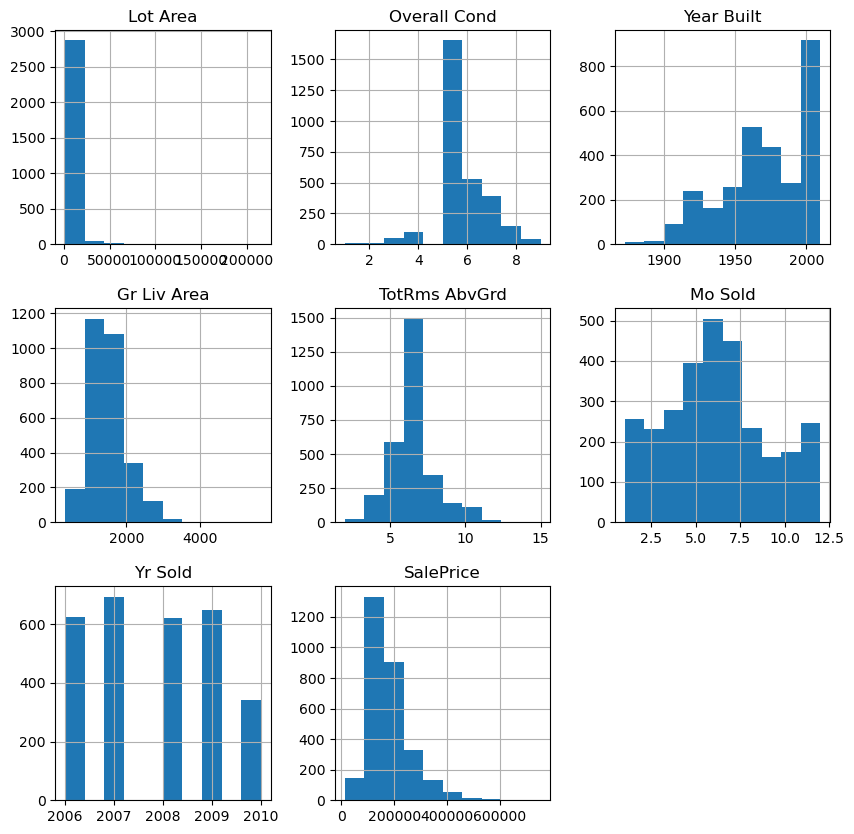

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]
ames.hist()
plt.show()

There might be some outliers in Lot Area we might want to remove, to improve model performance. For "Overall Cond", it looks like there is a gap: So let us make larger histogram for these two variables.

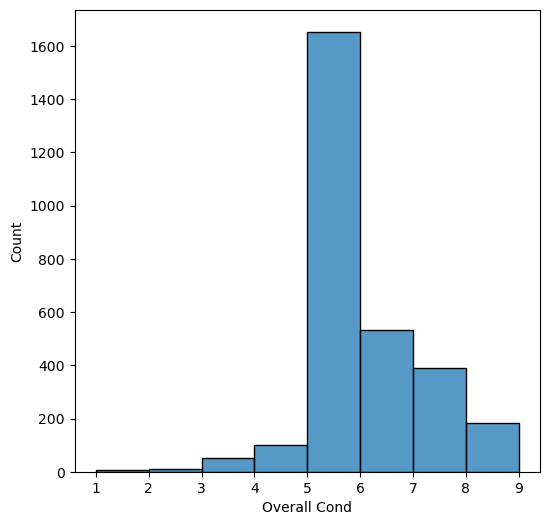

In [9]:
plt.rcParams['figure.figsize'] = [6,6]
sns.histplot(data = ames, x = "Overall Cond", binwidth=1)
plt.show()

There is no problem with the `Overall Cond` variable.

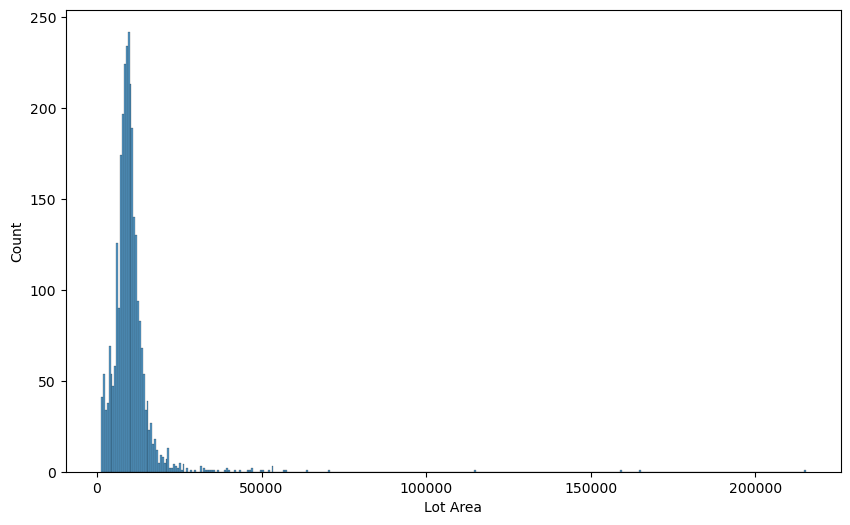

In [10]:
plt.rcParams['figure.figsize'] = [10,6]
sns.histplot(data = ames, x = "Lot Area")
plt.show()

There seems to be a few outliers for `Lot Area` that we might want to remove. Let us look at the data points with lot area above 75,000.

In [11]:
ames[ames["Lot Area"] > 75000]

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice
956,215245,5,1965,2036,8,6,2009,1Fam,Timber,375000
1570,164660,6,1965,1786,7,8,2008,2fmCon,Timber,228950
2071,115149,5,1971,1824,5,6,2007,1Fam,ClearCr,302000
2115,159000,7,1958,2144,7,6,2007,1Fam,ClearCr,277000


Let us remove these 4 values from our dataset.

In [12]:
ames = ames[ames["Lot Area"] <= 75000]

In [13]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2926 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Lot Area       2926 non-null   int64 
 1   Overall Cond   2926 non-null   int64 
 2   Year Built     2926 non-null   int64 
 3   Gr Liv Area    2926 non-null   int64 
 4   TotRms AbvGrd  2926 non-null   int64 
 5   Mo Sold        2926 non-null   int64 
 6   Yr Sold        2926 non-null   int64 
 7   Bldg Type      2926 non-null   object
 8   Neighborhood   2926 non-null   object
 9   SalePrice      2926 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 251.5+ KB


Let us now look at the two categorical variables. First `Bldg Type`.

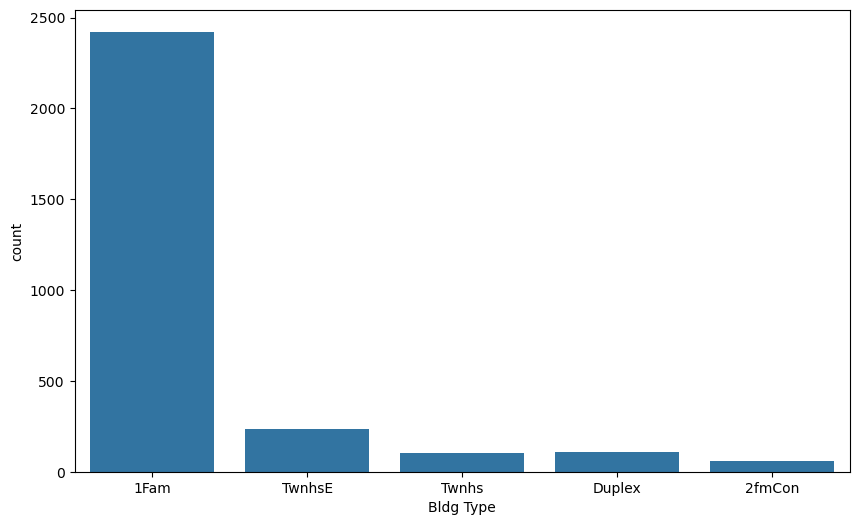

Bldg Type
1Fam      2422
TwnhsE     233
Duplex     109
Twnhs      101
2fmCon      61
Name: count, dtype: int64

In [14]:
sns.countplot(x = "Bldg Type", data = ames)
plt.show()
ames["Bldg Type"].value_counts()

It looks fine.

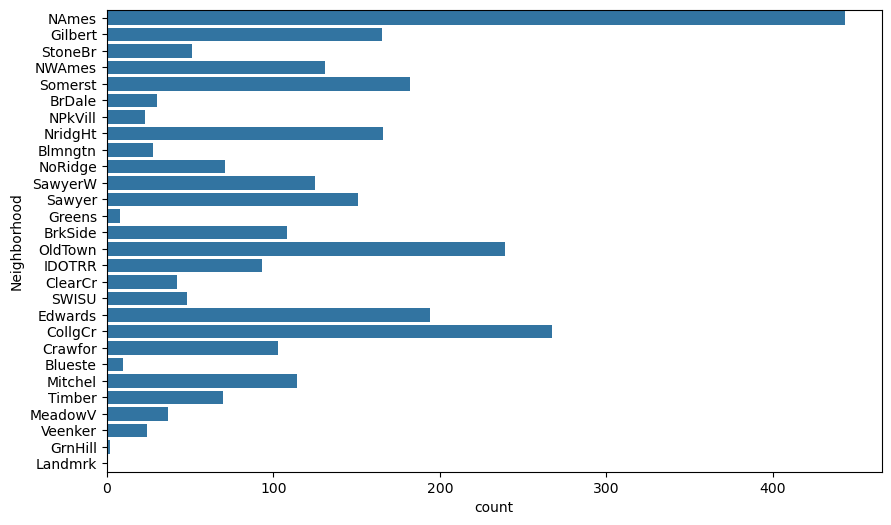

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
NoRidge     71
Timber      70
StoneBr     51
SWISU       48
ClearCr     42
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

In [15]:
sns.countplot(y = "Neighborhood", data = ames)
plt.show()
ames["Neighborhood"].value_counts()

It is clear that there are some neighborhoods where we have very little data. Thus, we will probably make very uncertain predictions for these neighborhoods. It might be worth thinking about how to tell the user this. Alternatively, we can exclude some neighborhoods from the app or find a way of making predictions for these neighborhoods based on other neighborhoods that somehow resemble them in regard to house prices.

Data now seems to be clean enough to train a first model.

### 5. Transform into proper format

We need to transform our categorical variables into dummy variables.

In [16]:
ames_wd = ames.join(pd.get_dummies(ames["Bldg Type"], drop_first=True, dtype = "int", prefix="BType"))
ames_wd.head()

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice,BType_2fmCon,BType_Duplex,BType_Twnhs,BType_TwnhsE
0,31770,5,1960,1656,7,5,2010,1Fam,NAmes,215000,0,0,0,0
1,11622,6,1961,896,5,6,2010,1Fam,NAmes,105000,0,0,0,0
2,14267,6,1958,1329,6,6,2010,1Fam,NAmes,172000,0,0,0,0
3,11160,5,1968,2110,8,4,2010,1Fam,NAmes,244000,0,0,0,0
4,13830,5,1997,1629,6,3,2010,1Fam,Gilbert,189900,0,0,0,0


In [17]:
ames_wd = ames_wd.join(pd.get_dummies(ames_wd["Neighborhood"], drop_first=True, dtype = "int", prefix="Nbh"))
ames_wd.head()

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice,...,Nbh_NoRidge,Nbh_NridgHt,Nbh_OldTown,Nbh_SWISU,Nbh_Sawyer,Nbh_SawyerW,Nbh_Somerst,Nbh_StoneBr,Nbh_Timber,Nbh_Veenker
0,31770,5,1960,1656,7,5,2010,1Fam,NAmes,215000,...,0,0,0,0,0,0,0,0,0,0
1,11622,6,1961,896,5,6,2010,1Fam,NAmes,105000,...,0,0,0,0,0,0,0,0,0,0
2,14267,6,1958,1329,6,6,2010,1Fam,NAmes,172000,...,0,0,0,0,0,0,0,0,0,0
3,11160,5,1968,2110,8,4,2010,1Fam,NAmes,244000,...,0,0,0,0,0,0,0,0,0,0
4,13830,5,1997,1629,6,3,2010,1Fam,Gilbert,189900,...,0,0,0,0,0,0,0,0,0,0


In [18]:
ames_wd = ames_wd.drop(columns = ["Bldg Type", "Neighborhood"])
ames_wd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2926 entries, 0 to 2929
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Lot Area       2926 non-null   int64
 1   Overall Cond   2926 non-null   int64
 2   Year Built     2926 non-null   int64
 3   Gr Liv Area    2926 non-null   int64
 4   TotRms AbvGrd  2926 non-null   int64
 5   Mo Sold        2926 non-null   int64
 6   Yr Sold        2926 non-null   int64
 7   SalePrice      2926 non-null   int64
 8   BType_2fmCon   2926 non-null   int64
 9   BType_Duplex   2926 non-null   int64
 10  BType_Twnhs    2926 non-null   int64
 11  BType_TwnhsE   2926 non-null   int64
 12  Nbh_Blueste    2926 non-null   int64
 13  Nbh_BrDale     2926 non-null   int64
 14  Nbh_BrkSide    2926 non-null   int64
 15  Nbh_ClearCr    2926 non-null   int64
 16  Nbh_CollgCr    2926 non-null   int64
 17  Nbh_Crawfor    2926 non-null   int64
 18  Nbh_Edwards    2926 non-null   int64
 19  Nbh_Gilbert

### 6. Create extra features

We could create extra features by multiplying existing features, but for now we will not bother. 

### 7. Train a baseline model

We will first make a test-train-validation split.

In [19]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import  mean_absolute_error

In [20]:
X_ames = ames_wd.drop(columns=["SalePrice"])
y_ames = ames_wd.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X_ames, y_ames, test_size=0.2, random_state=1742)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=4217)

In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1872, 38)
(468, 38)
(586, 38)
(1872,)
(468,)
(586,)


In [23]:
model_lmbase = linear_model.LinearRegression()
model_lmbase.fit(X_train, y_train)
y_pred_lmbase = model_lmbase.predict(X_val)

In [24]:
mean_absolute_error(y_val, y_pred_lmbase)

22223.517968600772

### 8. Try out different model types and architectures

We can try Decision Trees, Random Forest, Gradient Boosting, AdaBoost, Neural Networks, ...

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [26]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_val)
mean_absolute_error(y_val, y_pred_dt)

27321.393162393164

In [27]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)
mean_absolute_error(y_val, y_pred_rf)

19088.404924704922

In [28]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_val)
mean_absolute_error(y_val, y_pred_gb)

19891.857645776952

In [29]:
model_ab = AdaBoostRegressor()
model_ab.fit(X_train, y_train)
y_pred_ab = model_ab.predict(X_val)
mean_absolute_error(y_val, y_pred_ab)

30070.23107841645

neural networks ...

It seems like Random Forest or Gradient Boosting is the best...

### 9. Tune hyper-parameters to optimize model performance

We can tune hyper-parameters of Random Forest and Gradient Boosting. For simplicity, we are only going to try out with 100, 200, 500, and 1000 trees for each.

In [30]:
model_rf_100 = RandomForestRegressor(n_estimators=100)
model_rf_100.fit(X_train, y_train)
y_pred_rf_100 = model_rf_100.predict(X_val)
mean_absolute_error(y_val, y_pred_rf_100)

19460.59353032153

In [31]:
model_rf_200 = RandomForestRegressor(n_estimators=200)
model_rf_200.fit(X_train, y_train)
y_pred_rf_200 = model_rf_200.predict(X_val)
mean_absolute_error(y_val, y_pred_rf_200)

19250.7719763431

In [32]:
model_rf_500 = RandomForestRegressor(n_estimators=500)
model_rf_500.fit(X_train, y_train)
y_pred_rf_500 = model_rf_500.predict(X_val)
mean_absolute_error(y_val, y_pred_rf_500)

mlflow.sklearn.save_model(model_rf_500, "mlflow_rf_model")


In [33]:
model_rf_1000 = RandomForestRegressor(n_estimators=1000)
model_rf_1000.fit(X_train, y_train)
y_pred_rf_1000 = model_rf_1000.predict(X_val)
mean_absolute_error(y_val, y_pred_rf_1000)

19254.128842911414

In [34]:
model_gb_100 = GradientBoostingRegressor(n_estimators=100)
model_gb_100.fit(X_train, y_train)
y_pred_gb_100 = model_gb_100.predict(X_val)
mean_absolute_error(y_val, y_pred_gb_100)

19896.990733009327

In [35]:
model_gb_200 = GradientBoostingRegressor(n_estimators=200)
model_gb_200.fit(X_train, y_train)
y_pred_gb_200 = model_gb_200.predict(X_val)
mean_absolute_error(y_val, y_pred_gb_200)

19337.005617921677

In [36]:
model_gb_500 = GradientBoostingRegressor(n_estimators=500)
model_gb_500.fit(X_train, y_train)
y_pred_gb_500 = model_gb_500.predict(X_val)
mean_absolute_error(y_val, y_pred_gb_500)

19561.75752643116

In [37]:
model_gb_1000 = GradientBoostingRegressor(n_estimators=1000)
model_gb_1000.fit(X_train, y_train)
y_pred_gb_1000 = model_gb_1000.predict(X_val)
mean_absolute_error(y_val, y_pred_gb_1000)

20230.782092418136

It seems like the Random Forest model with 500 trees is the best model with a MAE of 19245...

In [38]:
model_final = model_rf_500

It is also clear that there are many many more experiments with hyper parameters we could try out and it easily gets hard to keep track of them all!

### 10. Test the model

We can now finally test the model final selected model (`model_rf_500`).

In [39]:
y_pred_test = model_final.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

19852.1996537326

## Potential problems of deploying this model to production

### Complex dependencies

- Other models could depend on our model. (An app feature predicting alternative houses in the same price range, an app feature that can tell the added value of renovating a house, ...)
- Real estate agents might use our app

### Feedback-loops

- If the prices are systematically underestimated, then sellers might start setting the prices too low, which will affect the data we might use for retraining the model in the future.
- The same can happen if real estate agents use our app

### Pipeline Jungles

- We might need to collect the different X variables from different sources and systems

### Configuration depts and dead experiments

- We saw how easy it is to create different model experiments
- These are prone to errors (did I actually copy-pasted the right code and changed all the right numbers)
- It can be costly to keep code for all these alternative models operational (especially if they use different engineered features)

### Process Management Debt

- This model might be the first model amongst many. We might later decide to do our model in R instead of Python.

### Reproducibility Debt 

- We can ensure reproducibility of our train-validation-test split by using random seeds, but did we remember?
- What about the random element involved in Random Forest?

### Changes in data and the real world 

**House prices changes due to inflation**
- We do have a `Yr Sold` that potentially could have picked up on historical inflation changes
- However, are we sure that this pattern is properly extrapolated based on the `Yr Sold` variable in the future. (The relationship between the `Yr Sold`and the `SalePrice` variables might change.)
- We might want to have separate inflation data from another source to put into the model or do a post hoc adjustment.

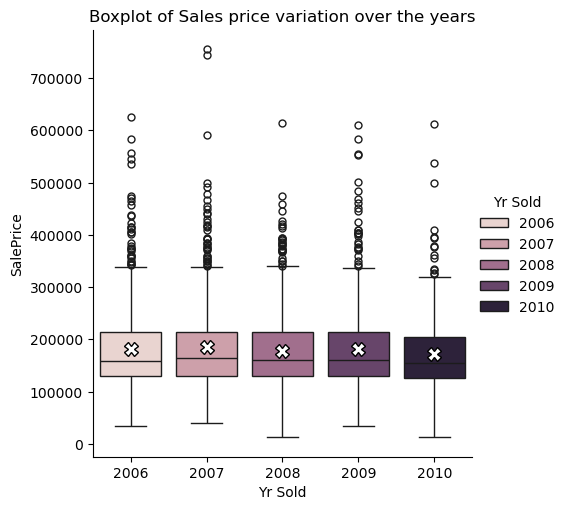

In [40]:
sns.catplot(x="Yr Sold", y = "SalePrice", hue = "Yr Sold", data = ames, kind="box",
            showmeans=True,
            meanprops={"marker":"X", "markerfacecolor":"white", "markeredgecolor":"black", "markersize": "10"})
plt.title("Boxplot of Sales price variation over the years")
plt.show()

<Axes: xlabel='Yr Sold', ylabel='SalePrice'>

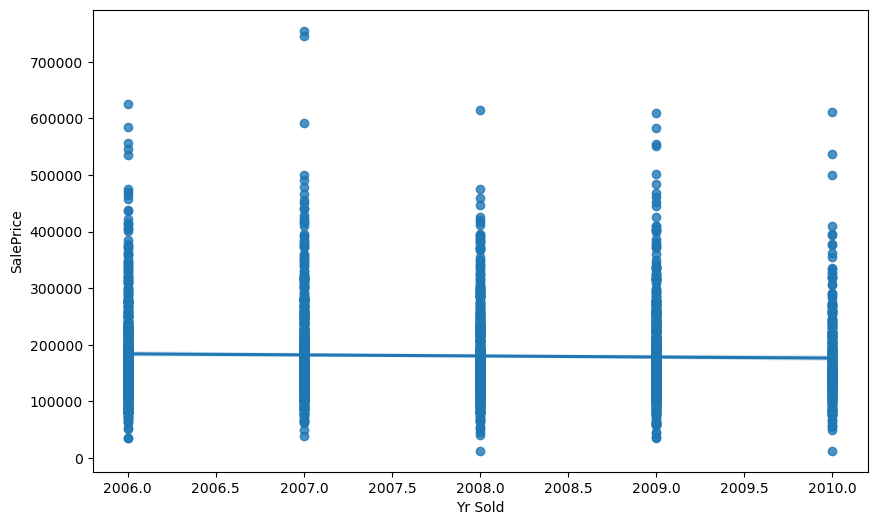

In [41]:
sns.regplot(x="Yr Sold", y="SalePrice", data=ames)

**Other global pattern changes in house prices**
- Changes to the loan interest rate might change the housing prices.
- Changes in housing taxation might change the housing prices.
- An extreme event, like the COVID-19 pandemic, might affect people's housing buying patterns.
- Suddenly increase in heating cost, might make people prefer smaller houses. (The relationship between the `Gr Liv Area` variable and the `SalePrice` variable changes.)

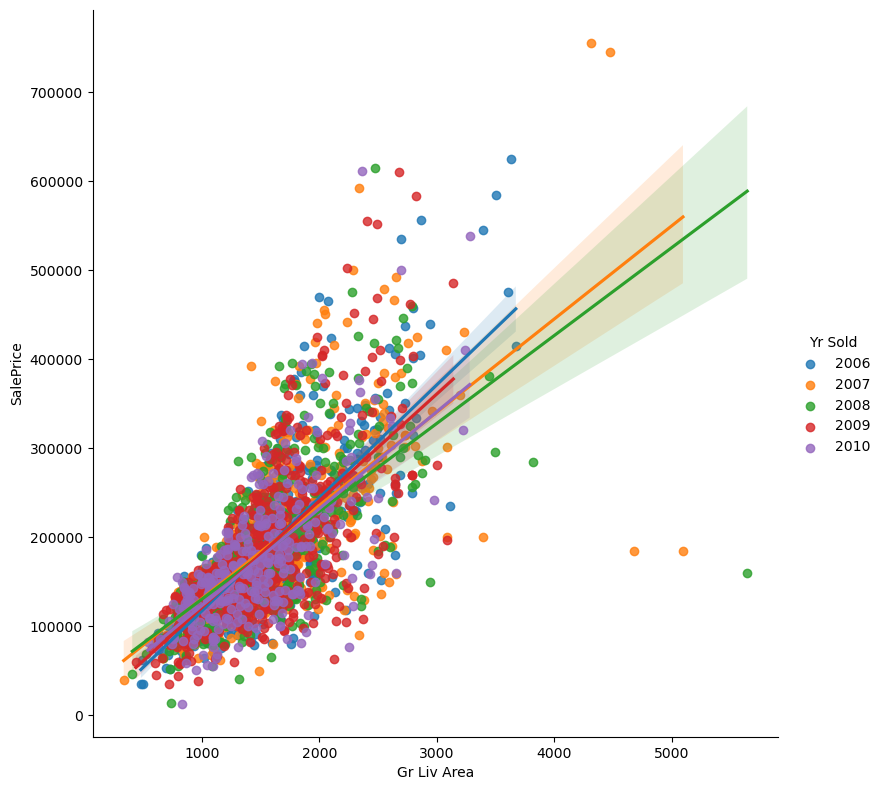

In [42]:
sns.pairplot(hue="Yr Sold", x_vars="Gr Liv Area", y_vars="SalePrice", data=ames, kind="reg", height=8)
plt.show()

**If changes happens to the relationship between the input/feature/independent variables and the target/dependent variable, we say that a *concept drift* has happened.**

**If changes happens to the distribution of the input variables we talk about *data drift*.**

**Examples of data drifts**

- Multiple new large apartment buildings in a neighborhood have finished construction and are put up for sales. If they are all large family apartments in a neighborhood with traditionally small apartments, then we see a change in the distribution of the `Gr Liv Area`, `TotRms AbvGrd`, `Bldg Type` variables. This might not change the performance of the model, as it might not result in concept drift. However, it might create new data points outside the input distribution the modal has been trained on. This again might increase the uncertainty of these predictions.
- The distribution of the `Yr Sold` variable will always change as the year passes.
- Maybe a new method of measuring Lot sizes is introduced, which will affect the distribution of the `Lot Area` variable. Maybe this will also change historical data, maybe it will not.
- A new Neighborhood is build or houses are sold in a Neighborhood that previously had no prior sales. This will result in a change in the distribution of the variable `Neighborhood`. Moreover, it might break the model, as we need to make a new dummy variable encoding with an extra new value.
- If we have scaled an input variable that suddenly drifts, then we might also have to change the rescaling.